# 实现一个图片分类应用

`Linux` `Windows` `Ascend` `GPU` `CPU` `全流程` `初级` `中级` `高级`

[![](https://gitee.com/mindspore/docs/raw/r1.3/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/r1.3/docs/mindspore/programming_guide/source_zh_cn/quick_start/quick_start.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/r1.3/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r1.3/programming_guide/zh_cn/mindspore_quick_start.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/r1.3/resource/_static/logo_modelarts.png)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9vYnMuZHVhbHN0YWNrLmNuLW5vcnRoLTQubXlodWF3ZWljbG91ZC5jb20vbWluZHNwb3JlLXdlYnNpdGUvbm90ZWJvb2svbW9kZWxhcnRzL21pbmRzcG9yZV9xdWlja19zdGFydC5pcHluYg==&imageid=65f636a0-56cf-49df-b941-7d2a07ba8c8c)&emsp;[![](https://gitee.com/mindspore/docs/raw/r1.3/resource/_static/logo_online_experience.png)](https://ascend.huawei.com/zh/#/college/onlineExperiment/codeLabMindSpore/mindSpore)

## 概述

下面我们通过一个实际样例，带领大家体验MindSpore基础的功能，对于一般的用户而言，完成整个样例实践会持续20~30分钟。

本例子会实现一个简单的图片分类的功能，整体流程如下：

1. 处理需要的数据集，这里使用了MNIST数据集。
2. 定义一个网络，这里我们使用LeNet网络。
3. 自定义回调函数收集模型的损失值和精度值。
4. 定义损失函数和优化器。
5. 加载数据集并进行训练，训练完成后，查看结果及保存模型文件。
6. 加载保存的模型，进行推理。
7. 验证模型，加载测试数据集和训练后的模型，验证结果精度。

这是简单、基础的应用流程，其他高级、复杂的应用可以基于这个基本流程进行扩展。

> 本文档适用于CPU、GPU和Ascend环境。  
> 你可以在这里找到完整可运行的样例代码：<https://gitee.com/mindspore/docs/tree/r1.3/docs/sample_code/lenet> 。

## 准备环节

在动手进行实践之前，确保，你已经正确安装了MindSpore。如果没有，可以通过[MindSpore安装页面](https://www.mindspore.cn/install)将MindSpore安装在你的电脑当中。  

同时希望你拥有Python编码基础和概率、矩阵等基础数学知识。

那么接下来，就开始MindSpore的体验之旅吧。

### 下载数据集

我们示例中用到的`MNIST`数据集是由10类$28*28$的灰度图片组成，训练数据集包含60000张图片，测试数据集包含10000张图片。

> MNIST数据集下载页面：<http://yann.lecun.com/exdb/mnist/>。页面提供4个数据集下载链接，其中前2个文件是训练数据需要，后2个文件是测试结果需要。

在Jupyter Notebook中执行如下命令下载MNIST数据集。

In [1]:
!mkdir -p ./datasets/MNIST_Data/train ./datasets/MNIST_Data/test
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte --no-check-certificate 
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte --no-check-certificate
!tree ./datasets/MNIST_Data

./datasets/MNIST_Data
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte

2 directories, 4 files


### 导入Python库&模块

在使用前，需要导入需要的Python库。

目前使用到`os`库，为方便理解，其他需要的库，我们在具体使用到时再说明。

In [2]:
import os

详细的MindSpore的模块说明，可以在[MindSpore API页面](https://www.mindspore.cn/docs/api/zh-CN/r1.3/index.html)中搜索查询。

### 配置运行信息

在正式编写代码前，需要了解MindSpore运行所需要的硬件、后端等基本信息。

可以通过`context.set_context`来配置运行需要的信息，譬如运行模式、后端信息、硬件等信息。

导入`context`模块，配置运行需要的信息。

In [3]:
from mindspore import context

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

在样例中我们配置样例运行使用图模式。根据实际情况配置硬件信息，譬如代码运行在Ascend AI处理器上，则`--device_target`选择`Ascend`，代码运行在CPU、GPU同理。详细参数说明，请参见`context.set_context`接口说明。

## 数据处理
数据集对于训练非常重要，好的数据集可以有效提高训练精度和效率，在加载数据集前，通常会对数据集进行一些处理。

由于后面会采用LeNet这样的卷积神经网络对数据集进行训练，而采用在训练数据时，对数据格式是有所要求的，所以接下来需要先查看数据集内的数据是什么样的，这样才能构造一个针对性的数据转换函数，将数据集数据转换成符合训练要求的数据形式。

执行如下代码查看原始数据集数据。

The type of mnist_ds: <class 'mindspore.dataset.engine.datasets.MnistDataset'>
Number of pictures contained in the mnist_ds： 60000
The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (28, 28, 1)
The label of item: 8


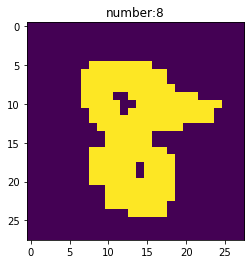

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import mindspore.dataset as ds

train_data_path = "./datasets/MNIST_Data/train"
test_data_path = "./datasets/MNIST_Data/test"
mnist_ds = ds.MnistDataset(train_data_path)
print('The type of mnist_ds:', type(mnist_ds))
print("Number of pictures contained in the mnist_ds：", mnist_ds.get_dataset_size())

dic_ds = mnist_ds.create_dict_iterator()
item = next(dic_ds)
img = item["image"].asnumpy()
label = item["label"].asnumpy()

print("The item of mnist_ds:", item.keys())
print("Tensor of image in item:", img.shape) 
print("The label of item:", label)

plt.imshow(np.squeeze(img))
plt.title("number:%s"% item["label"].asnumpy())
plt.show()

从上面的运行情况我们可以看到，训练数据集`train-images-idx3-ubyte`和`train-labels-idx1-ubyte`对应的是6万张图片和6万个数字标签，载入数据后经过`create_dict_iterator`转换字典型的数据集，取其中的一个数据查看，这是一个key为`image`和`label`的字典，其中的`image`的张量(高度28，宽度28，通道1)和`label`为对应图片的数字。

### 定义数据集及数据操作

我们定义一个函数`create_dataset`来创建数据集。在这个函数中，我们定义好需要进行的数据增强和处理操作：

1. 定义数据集。
2. 定义进行数据增强和处理所需要的一些参数。
3. 根据参数，生成对应的数据增强操作。
4. 使用`map`映射函数，将数据操作应用到数据集。
5. 对生成的数据集进行处理。

定义完成后，使用`create_datasets`对原始数据进行增强操作，并抽取一个`batch`的数据，查看数据增强后的变化。

In [5]:
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """ 
    create dataset for train or test
    
    Args:
        data_path (str): Data path
        batch_size (int): The number of data records in each group
        repeat_size (int): The number of replicated data records
        num_parallel_workers (int): The number of parallel workers
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # according to the parameters, generate the corresponding data enhancement method
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # using map to apply operations to a dataset
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    
    # process the generated dataset
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

ms_dataset = create_dataset(train_data_path)
print('Number of groups in the dataset:', ms_dataset.get_dataset_size())

Number of groups in the dataset: 1875


调用数据增强函数后，查看数据集`size`由60000变成了1875，符合我们的数据增强中`mnist_ds.batch`操作的预期（$60000/32=1875$）。

上述增强过程中：

- 数据集中的`label`数据增强操作：

  - `C.TypeCast`：将数据类型转化为`int32`。

- 数据集中的`image`数据增强操作：  

  - `datasets.MnistDataset`：将数据集转化为MindSpore可训练的数据。  
  - `CV.Resize`：对图像数据像素进行缩放，适应LeNet网络对数据的尺寸要求。  
  - `CV.Rescale`：对图像数据进行标准化、归一化操作，使得每个像素的数值大小在（0,1）范围中，可以提升训练效率。  
  - `CV.HWC2CHW`：对图像数据张量进行变换，张量形式由`高x宽x通道`（HWC）变为`通道x高x宽`（CHW），方便进行数据训练。
 
- 其他增强操作：

  - `mnist_ds.shuffle`：随机将数据存放在可容纳10000张图片地址的内存中进行混洗。  
  - `mnist_ds.batch`：从混洗的10000张图片地址中抽取32张图片组成一个`batch`，参数`batch_size`表示每组包含的数据个数，现设置每组包含32个数据。  
  - `mnist_ds.repeat`：将`batch`数据进行复制增强，参数`repeat_size`表示数据集复制的数量。

先进行`shuffle`、`batch`操作，再进行`repeat`操作，这样能保证1个`epoch`内数据不重复。

> MindSpore支持进行多种数据处理和增强的操作，各种操作往往组合使用，具体可以参考[数据处理](https://www.mindspore.cn/docs/programming_guide/zh-CN/r1.3/pipeline.html)和与[数据增强](https://www.mindspore.cn/docs/programming_guide/zh-CN/r1.3/augmentation.html)章节。

### 查看增强后的数据

从1875组数据中取出一组数据，查看其数据张量及`label`。

In [6]:
data = next(ms_dataset.create_dict_iterator(output_numpy=True))
images = data["image"]
labels = data["label"]
print('Tensor of image:', images.shape)
print('Labels:', labels)

Tensor of image: (32, 1, 32, 32)
Labels: [9 8 5 5 1 2 3 5 7 0 6 1 0 3 8 1 2 1 5 1 5 2 8 4 4 6 4 5 5 5 7 8]


将张量数据和`label`对应的值进行可视化。

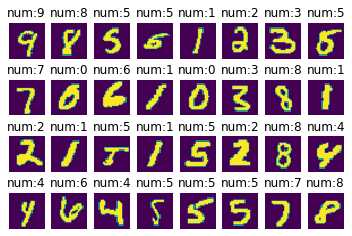

In [7]:
count = 1
for i in images:
    plt.subplot(4, 8, count) 
    plt.imshow(np.squeeze(i))
    plt.title('num:%s'%labels[count-1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()

通过上述查询操作，看到经过变换后的图片，数据集内分成了1875组数据，每组数据中含有32张图片，每张图片像数值为32×32，数据全部准备好后，就可以进行下一步的数据训练了。

## 定义网络

我们选择相对简单的LeNet网络。LeNet网络不包括输入层的情况下，共有7层：2个卷积层、2个下采样层（池化层）、3个全连接层。每层都包含不同数量的训练参数，如下图所示：

<img src="https://gitee.com/mindspore/docs/raw/r1.3/docs/mindspore/programming_guide/source_zh_cn/quick_start/images/LeNet_5.png" alt="LeNet5">

> 更多的LeNet网络的介绍不在此赘述，希望详细了解LeNet网络，可以查询<http://yann.lecun.com/exdb/lenet/>。

在构建LeNet前，我们对全连接层以及卷积层采用Normal进行参数初始化。

MindSpore支持`TruncatedNormal`、`Normal`、`Uniform`等多种参数初始化方法，具体可以参考MindSpore API的`mindspore.common.initializer`模块说明。

使用MindSpore定义神经网络需要继承`mindspore.nn.Cell`，`Cell`是所有神经网络（`Conv2d`等）的基类。

神经网络的各层需要预先在`__init__`方法中定义，然后通过定义`construct`方法来完成神经网络的前向构造，按照LeNet的网络结构，定义网络各层如下：

In [8]:
import mindspore.nn as nn
from mindspore.common.initializer import Normal

class LeNet5(nn.Cell):
    """Lenet network structure."""
    # define the operator required
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.max_pool2d(self.relu(self.conv1(x)))
        x = self.max_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) 
        return x
    
network = LeNet5()
print("layer conv1:", network.conv1)
print("*"*40)
print("layer fc1:", network.fc1)

layer conv1: Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5),stride=(1, 1),  pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=Falseweight_init=normal, bias_init=zeros, format=NCHW>
****************************************
layer fc1: Dense<input_channels=400, output_channels=120, has_bias=True>


构建完成后，可以使用`print(LeNet5())`将神经网络中的各层参数全部打印出来，也可以使用`LeNet().{layer名称}`打印相应的参数信息。本例选择打印第一个卷积层和第一个全连接层的相应参数。

## 自定义回调函数收集模型的损失值和精度值

自定义一个数据收集的回调类`StepLossAccInfo`，用于收集两类信息：

1. 训练过程中`step`和`loss`值之间关系的信息；
2. 每训练125个`step`和对应模型精度值`accuracy`的信息。

该类继承了`Callback`类，可以自定义训练过程中的操作，等训练完成后，可将数据绘成图查看`step`与`loss`的变化情况，以及`step`与`accuracy`的变化情况。

以下代码会作为回调函数，在模型训练函数`model.train`中调用，本文验证模型阶段会将收集到的信息，进行可视化展示。

In [9]:
from mindspore.train.callback import Callback

# custom callback function
class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.steps_loss = steps_loss
        self.steps_eval = steps_eval
        
    def step_end(self, run_context):
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        cur_step = (cur_epoch-1)*1875 + cb_params.cur_step_num
        self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
        self.steps_loss["step"].append(str(cur_step))
        if cur_step % 125 == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])

其中：

- `model`：计算图模型Model。
- `eval_dataset`：验证数据集。
- `steps_loss`：收集step和loss值之间的关系，数据格式`{"step": [], "loss_value": []}`。
- `steps_eval`：收集step对应模型精度值`accuracy`的信息，数据格式为`{"step": [], "acc": []}`。

## 定义损失函数及优化器

在进行定义之前，先简单介绍损失函数及优化器的概念。

- 损失函数：又叫目标函数，用于衡量预测值与实际值差异的程度。深度学习通过不停地迭代来缩小损失函数的值。定义一个好的损失函数，可以有效提高模型的性能。

- 优化器：用于最小化损失函数，从而在训练过程中改进模型。

定义了损失函数后，可以得到损失函数关于权重的梯度。梯度用于指示优化器优化权重的方向，以提高模型性能。

MindSpore支持的损失函数有`SoftmaxCrossEntropyWithLogits`、`L1Loss`、`MSELoss`等。这里使用`SoftmaxCrossEntropyWithLogits`损失函数。

MindSpore支持的优化器有`Adam`、`AdamWeightDecay`、`Momentum`等。这里使用流行的`Momentum`优化器。

In [10]:
import mindspore.nn as nn
from mindspore.nn import SoftmaxCrossEntropyWithLogits

lr = 0.01
momentum = 0.9 

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

## 训练网络

完成神经网络的构建后，就可以着手进行网络训练了，通过MindSpore提供的`Model.train`接口可以方便地进行网络的训练，参数主要包含：

1. 每个`epoch`需要遍历完成图片的batch数：`epoch_size`；  
2. 训练数据集`ds_train`；  
3. MindSpore提供了callback机制，回调函数`callbacks`，包含`ModelCheckpoint`、`LossMonitor`和`Callback`模型检测参数；其中`ModelCheckpoint`可以保存网络模型和参数，以便进行后续的fine-tuning（微调）操作；    
4. 数据下沉模式`dataset_sink_mode`，此参数默认`True`需设置成`False`，因为此模式不支持CPU计算平台。

In [11]:
import os
from mindspore import Tensor, Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.nn import Accuracy

epoch_size = 1
mnist_path = "./datasets/MNIST_Data"
model_path = "./models/ckpt/mindspore_quick_start/"

repeat_size = 1
ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)
eval_dataset = create_dataset(os.path.join(mnist_path, "test"), 32)

# clean up old run files before in Linux
os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))

# define the model
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()} )

# save the network model and parameters for subsequence fine-tuning
config_ck = CheckpointConfig(save_checkpoint_steps=375, keep_checkpoint_max=16)
# group layers into an object with training and evaluation features
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", directory=model_path, config=config_ck)

steps_loss = {"step": [], "loss_value": []}
steps_eval = {"step": [], "acc": []}
# collect the steps,loss and accuracy information
step_loss_acc_info = StepLossAccInfo(model , eval_dataset, steps_loss, steps_eval)

model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(125), step_loss_acc_info], dataset_sink_mode=False)

epoch: 1 step: 125, loss is 2.2961428
epoch: 1 step: 250, loss is 2.2972755
epoch: 1 step: 375, loss is 2.2992194
epoch: 1 step: 500, loss is 2.3089285
epoch: 1 step: 625, loss is 2.304193
epoch: 1 step: 750, loss is 2.3023324
epoch: 1 step: 875, loss is 0.69262105
epoch: 1 step: 1000, loss is 0.23356618
epoch: 1 step: 1125, loss is 0.35567114
epoch: 1 step: 1250, loss is 0.2065609
epoch: 1 step: 1375, loss is 0.19551893
epoch: 1 step: 1500, loss is 0.1836512
epoch: 1 step: 1625, loss is 0.028234977
epoch: 1 step: 1750, loss is 0.1124336
epoch: 1 step: 1875, loss is 0.026502304


训练完成后，会在设置的模型保存路径上生成多个模型文件。

In [12]:
!tree $model_path

./models/ckpt/mindspore_quick_start/
├── checkpoint_lenet-1_1125.ckpt
├── checkpoint_lenet-1_1500.ckpt
├── checkpoint_lenet-1_1875.ckpt
├── checkpoint_lenet-1_375.ckpt
├── checkpoint_lenet-1_750.ckpt
└── checkpoint_lenet-graph.meta

0 directories, 6 files


文件名称具体含义`{ModelCheckpoint中设置的自定义名称}-{第几个epoch}_{第几个step}.ckpt`。

> 使用自由控制循环的迭代次数、遍历数据集等，可以参照官网编程指南《[训练](https://www.mindspore.cn/docs/programming_guide/zh-CN/r1.3/train.html#%E8%87%AA%E5%AE%9A%E4%B9%89%E8%AE%AD%E7%BB%83%E5%BE%AA%E7%8E%AF)》的自定义循环训练部分。


### 查看模型损失值随着训练步数的变化情况

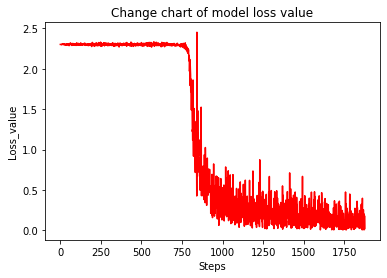

In [13]:
steps = steps_loss["step"]
loss_value = steps_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Change chart of model loss value")
plt.show()

从上面可以看出来大致分为三个阶段：

阶段一：训练开始时，loss值在2.2上下浮动，训练收益感觉并不明显。

阶段二：训练到某一时刻，loss值迅速减少，训练收益大幅增加。

阶段三：loss值收敛到一定小的值后，开始振荡在一个小的区间上无法趋0，再继续增加训练并无明显收益，至此训练结束。

##  验证模型

得到模型文件后，通过运行测试数据集得到的结果，验证模型的泛化能力。

搭建测试网络来验证模型的过程主要为：

1. 载入模型`.ckpt`文件中的参数`param_dict`；
2. 将参数`param_dict`载入到神经网络LeNet中；
3. 载入测试数据集；
4. 调用函数`model.eval`传入参数测试数据集`ds_eval`，生成模型`checkpoint_lenet-{epoch}_1875.ckpt`的精度值。

In [14]:
from mindspore import load_checkpoint, load_param_into_net

# testing relate modules 
def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("./models/ckpt/mindspore_quick_start/checkpoint_lenet-1_1875.ckpt")
    # load parameter to the network
    load_param_into_net(network, param_dict)
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=False)
    print("============== Accuracy:{} ==============".format(acc))

test_net(network, model, mnist_path)

============== Starting Testing ==============
============== Accuracy:{'Accuracy': 0.9697516025641025} ==============


其中：

- `load_checkpoint`：通过该接口加载CheckPoint模型参数文件，返回一个参数字典。

- `checkpoint_lenet-1_1875.ckpt`：之前保存的CheckPoint模型文件名称。

- `load_param_into_net`：通过该接口把参数加载到网络中。

经过1875步训练后生成的模型精度超过95%，模型优良。

我们可以看一下模型随着训练步数变化，精度随之变化的情况。

`eval_show`将绘制每25个`step`与模型精度值的折线图，其中`steps_eval`存储着模型的step数和对应模型精度值信息。

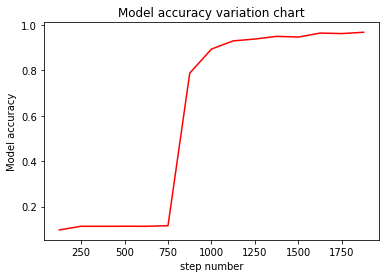

In [15]:
def eval_show(steps_eval):
    plt.xlabel("step number")
    plt.ylabel("Model accuracy")
    plt.title("Model accuracy variation chart")
    plt.plot(steps_eval["step"], steps_eval["acc"], "red")
    plt.show()

eval_show(steps_eval)

从图中可以看出训练得到的模型精度变化分为三个阶段：

阶段一：训练开始时，模型精度缓慢震荡上升。

阶段二：训练到某一时刻，模型精度迅速上升。

阶段三：缓慢上升趋近于不到1的某个值时附近振荡。

整个训练过程，随着训练数据的增加，会对模型精度有着正相关的影响，但是随着精度到达一定程度，训练收益会降低。

## 推理预测

我们使用生成的模型应用到分类预测单个或者单组图片数据上，具体步骤如下：

1. 将要测试的数据转换成适应LeNet的数据类型。
2. 提取出`image`的数据。
3. 使用函数`model.predict`预测`image`对应的数字。需要说明的是`predict`返回的是`image`对应0-9的概率值。
4. 调用`plot_pie`将预测出的各数字的概率显示出来。负概率的数字会被去掉。

载入要预测的数据集，并调用`create_dataset`转换成符合格式要求的数据集，并选取其中一组32张图片进行推理预测。

Row 1, column 2 is incorrectly identified as 8, the correct value should be 2 

Row 3, column 7 is incorrectly identified as 9, the correct value should be 4 

[5 8 0 2 7 4 1 7 8 6 6 8 7 9 5 8 7 2 0 4 5 9 9 3 9 1 3 9 7 6 3 4] <--Predicted figures
[5 2 0 2 7 4 1 7 8 6 6 8 7 9 5 8 7 2 0 4 5 9 4 3 9 1 3 9 7 6 3 4] <--The right number


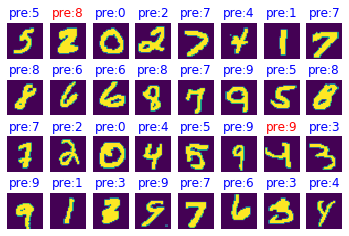

In [16]:
ds_test = create_dataset(test_data_path).create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

output = model.predict(Tensor(data['image']))
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i+1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i/8)+1, i%8+1, pred[i], labels[i]), '\n')
if index:
    print("All the figures in this group are predicted correctly!")
print(pred, "<--Predicted figures") 
print(labels, "<--The right number")
plt.show()

构建一个概率分析的饼图函数，本例展示了当前`batch`中的第一张图片的分析饼图。

`prb`存储了上面这组32张预测数字和对应的输出结果，取出第一张图片对应[0-9]分类结果`prb[0]`，带入sigmol公式$\frac{1}{1+e^{-x}}$，得到该图片对应[0-9]的概率，将概率值0.5以上的数字组成饼图分析。

The probability of corresponding numbers [0-9] in Figure 1:
 [0.16316024637045334, 0.04876983802517727, 0.02261393383191808, 0.9963960715325838, 0.037634749376478496, 0.998856840107891, 0.1612087582052347, 0.08714517716531343, 0.6207903209907534, 0.9653037548477632]


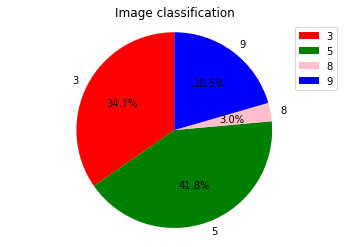

In [17]:
import numpy as np
# define the pie drawing function of probability analysis

prb = output.asnumpy()

def plot_pie(prbs):
    dict1 = {}
    # remove the negative number and build the dictionary dict1. The key is the number and the value is the probability value
    for i in range(10):
        if prbs[i] > 0:
            dict1[str(i)] = prbs[i]

    label_list = dict1.keys()
    size = dict1.values()
    colors = ["red", "green", "pink", "blue", "purple", "orange", "gray"] 
    color = colors[: len(size)]
    plt.pie(size, colors=color, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
    plt.axis("equal")
    plt.legend()
    plt.title("Image classification")
    plt.show()


print("The probability of corresponding numbers [0-9] in Figure 1:\n", list(map(lambda x:1/(1+np.exp(-x)), prb[0])))
plot_pie(prb[0])

以上就是这次手写数字分类应用的全部体验过程。